In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 500)

#### The csv file is over 10 gb. As such, I loaded the file in chunks, only selecting 2017 data, and saved the output to a new csv file

In [2]:
# csv_file = '311_Service_Requests_from_2010_to_Present.csv'

In [3]:
# iter_csv = pd.read_csv(csv_file, iterator=True, chunksize=1000, parse_dates=['Created Date'])
# df = pd.concat([chunk[chunk['Created Date'].dt.year == 2017] for chunk in iter_csv])
# df.to_csv('2017_data.csv')

In [4]:
df = pd.read_csv('2017_data.csv')

/Users/sean/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9,18,32,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# 2.5 million lines
df.shape[0]

2445422

#### Removing whitespaces and capitalization from column names, dropping unnecessary columns

In [6]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.drop(['unnamed:_0', 'unique_key', 'created_date', 'closed_date', 'open_data_channel_type', 'resolution_description', 'latitude', 'longitude',
         'landmark','vehicle_type', 'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name', 'bridge_highway_direction', 'road_ramp', 
         'bridge_highway_segment', 'agency', 'agency_name', 'location_type', 'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
         'intersection_street_1', 'intersection_street_2', 'address_type', 'city', 'facility_type', 'status', 'due_date', 'resolution_action_updated_date',
         'community_board', 'bbl', 'descriptor', 'x_coordinate_(state_plane)', 'y_coordinate_(state_plane)',
         'park_facility_name', 'park_borough'], axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2445422 entries, 0 to 2445421
Data columns (total 4 columns):
complaint_type    object
incident_zip      object
borough           object
location          object
dtypes: object(4)
memory usage: 74.6+ MB


#### Data Munging and Exploratory Data Analysis

In [8]:
df['borough'] = df['borough'].str.lower()                # make borough lowercase
df['location'] = df['location'].str.strip('()')          # remove paranthesis from location
df['location'] = df['location'].str.replace(' ', '')     # remove whitespace from location
df['complaint_type'] = df['complaint_type'].str.lower()  # make complaint_type lowercase
df.rename(columns={'incident_zip': 'zip'}, inplace=True) # rename incident_zip to zip
df['zip'] = pd.to_numeric(df['zip'], errors='coerce')    # turns zip codes into floats and convert non-integer non-floats to NaN
df['zip'].fillna(0, inplace=True)                        # convert NaN to zero -- integer column cannot contain NaN
df['zip'] = df['zip'].astype(int)                        # convert datatype of zip to integer -- eliminates .0 from zip codes

In [9]:
# 41,500 unspecified lines for borough
df['borough'].value_counts()

brooklyn         760965
queens           586910
manhattan        480298
bronx            449048
staten island    126717
unspecified       41484
Name: borough, dtype: int64

In [10]:
df[df['zip'] == 11208]['borough'].value_counts()

brooklyn       28289
queens            91
unspecified       14
Name: borough, dtype: int64

#### It appears that 184 zip codes have at least 2 boroughs

In [11]:
# group zip and borough by zip, and aggregate the count of borough for each zip code
gby = df[['zip', 'borough']].groupby('zip').agg({'borough': pd.Series.nunique})

zips_multiple_boroughs = gby[gby['borough'] != 1].index
print('zip codes with multiple boroughs:             {}'.format(len(zips_multiple_boroughs)))
print('number of lines that include these zip codes: {}'.format(df[df['zip'].isin(zips_multiple_boroughs)].shape[0]))

zip codes with multiple boroughs:             184
number of lines that include these zip codes: 2415046


#### Filling in the most commonly occuring zip code for the 184 zip codes

In [12]:
# take the count of occurances for each borough for each zip code, and mask the borough
# with the greatest number of occurances to all lines for the current iteration's zip code
for z in zips_multiple_boroughs:
    unspecified_zips = []
    d = pd.Series.to_dict(df[df['zip'] == z]['borough'].value_counts())
    max_count = 0
    for k in d.keys():
        if d[k] > max_count:
            max_count = d[k]
            true_borough = k
    if true_borough == 'unspecified':
        print('unspecified has the most entries for zip {}'.format(z))
        unspecified_zips.append(z)
    else:
        df.loc[(df['zip'] == z), 'borough'] = true_borough

unspecified has the most entries for zip 0
unspecified has the most entries for zip 10108
unspecified has the most entries for zip 10580
unspecified has the most entries for zip 10710
unspecified has the most entries for zip 11030
unspecified has the most entries for zip 11096
unspecified has the most entries for zip 11559
unspecified has the most entries for zip 11563
unspecified has the most entries for zip 11581


#### Now only 7 zip codes contain 38 incidents with at least 2 boroughs

In [13]:
gby = df[['zip', 'borough']].groupby('zip').agg({'borough': pd.Series.nunique})
zips_multiple_boroughs = gby[gby['borough'] != 1].index
# remove zip 0 (NaN value) from zips_multiple_boroughs
zips_multiple_boroughs = zips_multiple_boroughs[1:]
print('zip codes with multiple boroughs:             {}'.format(len(zips_multiple_boroughs)))
print('number of lines that include these zip codes: {}'.format(df[df['zip'].isin(zips_multiple_boroughs)].shape[0]))

zip codes with multiple boroughs:             8
number of lines that include these zip codes: 40


#### Further zip code manipulation:
- 102,000 zip codes are NaN
- 65,000 entries have boroughs and don't have zip codes

In [14]:
print('Null Zip Codes:                {}'.format(df[df['zip'] == 0].shape[0]))
print('Null Zip Codes (with borough): {}\n'.format(df[(df['zip'] == 0) & (df['borough'] != 'unspecified')].shape[0]))
print('Distribution of null codes with borough:')
print(df[(df['zip'] == 0) & (df['borough'] != 'unspecified')]['borough'].value_counts())

Null Zip Codes:                102231
Null Zip Codes (with borough): 65121

Distribution of null codes with borough:
manhattan        17958
bronx            16052
queens           15260
brooklyn         14642
staten island     1209
Name: borough, dtype: int64


In [15]:
# aggregate borough and zip to get a count of the most frequently occuring zip code for each borough
df_z = df[['borough', 'zip', 'location']].groupby(['borough', 'zip']) \
                                         .count() \
                                         .reset_index() \
                                         .sort_values(['borough', 'location'], ascending=False) \
                                         .set_index(['borough', 'zip'])

In [16]:
# set the most populous zip code for each borough to a variable
brx = df_z.xs('bronx').head(1).index[0]
bk  = df_z.xs('brooklyn').head(1).index[0]
mhn = df_z.xs('manhattan').head(1).index[0]
qns = df_z.xs('queens').head(1).index[0]
sid = df_z.xs('staten island').head(1).index[0]

# mask these variables to null zip values where the borough is known
df.loc[(df['zip'] == 0) & (df['borough'] == 'bronx'), 'zip'] = brx
df.loc[(df['zip'] == 0) & (df['borough'] == 'brooklyn'), 'zip'] = bk
df.loc[(df['zip'] == 0) & (df['borough'] == 'manhattan'), 'zip'] = mhn
df.loc[(df['zip'] == 0) & (df['borough'] == 'queens'), 'zip'] = qns
df.loc[(df['zip'] == 0) & (df['borough'] == 'staten island'), 'zip'] = sid

del df_z

#### Now only 37,000 zip codes remain NaN, these do not have a borough, and will be dropped

In [17]:
# now only 37110 zip codes are null, these do not have a borough
print('Null Zip Codes:                   {}'.format(df[df['zip'] == 0].shape[0]))
print('Null Zip Codes (with borough):    {}'.format(df[(df['zip'] == 0) & (df['borough'] != 'unspecified')].shape[0]))
print('Null Zip Codes (without borough): {}'.format(df[(df['zip'] == 0) & (df['borough'] == 'unspecified')].shape[0]))

Null Zip Codes:                   37110
Null Zip Codes (with borough):    0
Null Zip Codes (without borough): 37110


In [18]:
df = df[df['borough'] != 'unspecified'].copy()

#### Loading in the 2010 population census dataset -- use this to generate a value for population for each borough

In [19]:
population = pd.read_csv('2010_Census_Population_By_Zipcode.csv', names=['zip', 'population'], skiprows=1)

In [20]:
population.head()

,zip,population
0,1001,16769
1,1002,29049
2,1003,10372
3,1005,5079
4,1007,14649


In [21]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33092 entries, 0 to 33091
Data columns (total 2 columns):
zip           33092 non-null int64
population    33092 non-null int64
dtypes: int64(2)
memory usage: 517.1 KB


#### Adding a population column to the main DataFrame

In [22]:
df = df.merge(population, how='left', on='zip')

## Part 1
---

#### Consider only the 10 most common overall complaint types. For each borough, how many of each of those 10 types were there in 2017?
#### First, group data by complaint type to get the ten most common overall complaint types

In [23]:
df_c = df[['complaint_type', 'location']].groupby(by=['complaint_type']) \
                                         .count() \
                                         .sort_values(by=['location'], ascending=False)
df_c.rename(columns={'location':'count'}, inplace=True)

In [24]:
common_complaints = df_c.head(10).index
df_c.head(10)

,count
complaint_type,
noise - residential,229640
heat/hot water,213477
illegal parking,145163
blocked driveway,135551
street condition,89389
unsanitary condition,79260
noise - street/sidewalk,72663
water system,63440
noise,59154


#### Noise-related complaints hold three positions in the top ten.

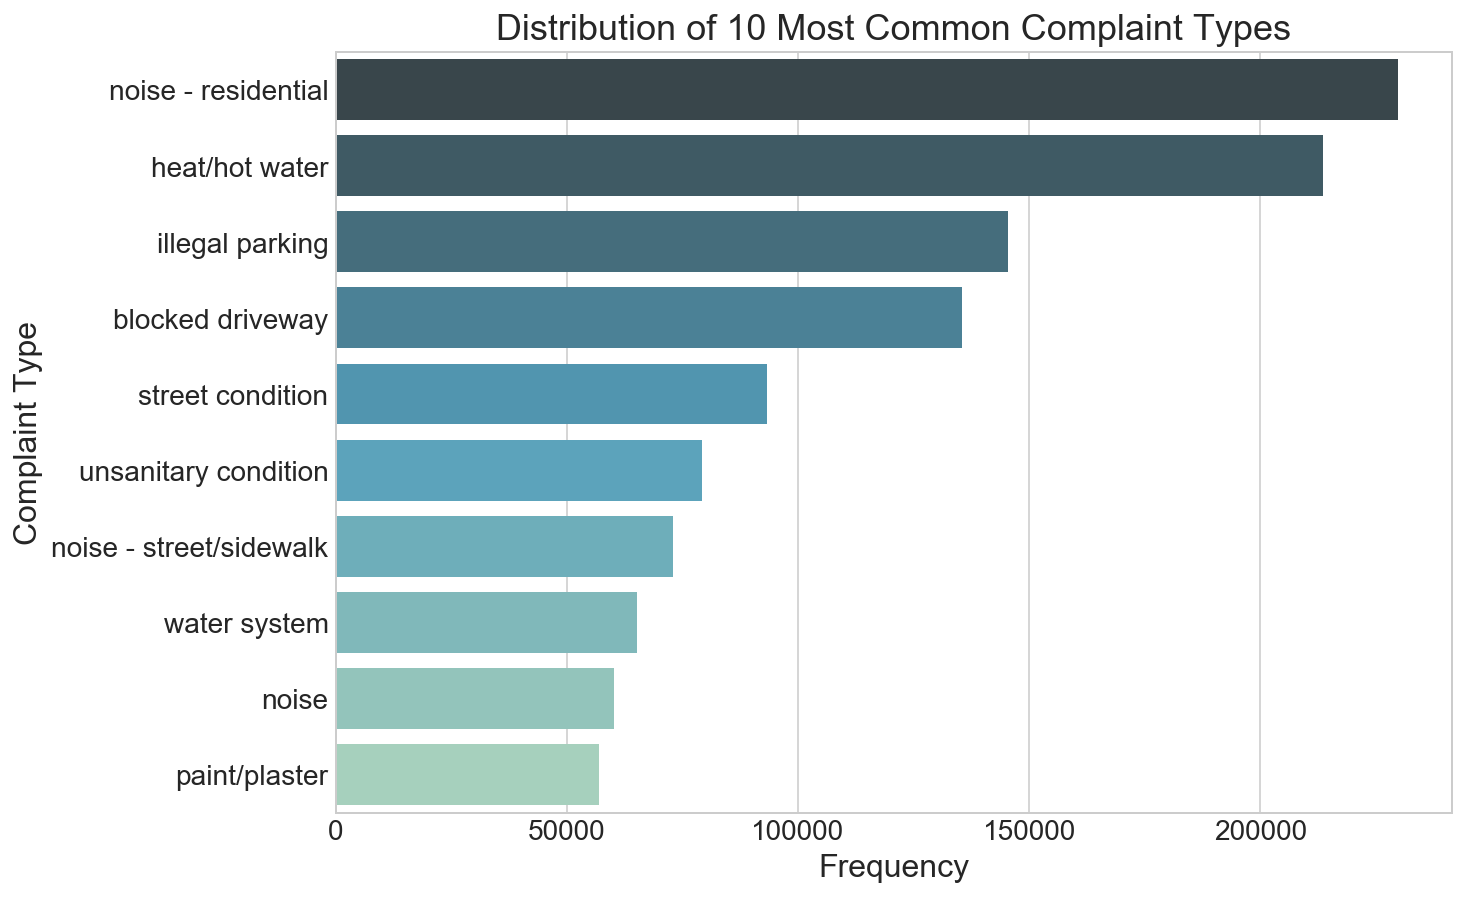

In [25]:
data = df[df['complaint_type'].isin(common_complaints)]

plt.figure(figsize = (10,7))

sns.countplot(y=data['complaint_type'],
              order=data['complaint_type'].value_counts().index,
              palette='GnBu_d')

plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Complaint Type', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Distribution of 10 Most Common Complaint Types', fontsize=18);

#### Looking at this data across each borough individually, we see the following:
- Brooklyn has problems with water and noise
- Staten Island has problems with roads and parking
- Queens has problems with noise and blocked driveways
- Manhattan has problems with noise and water
- Bronx has problems with water and noise

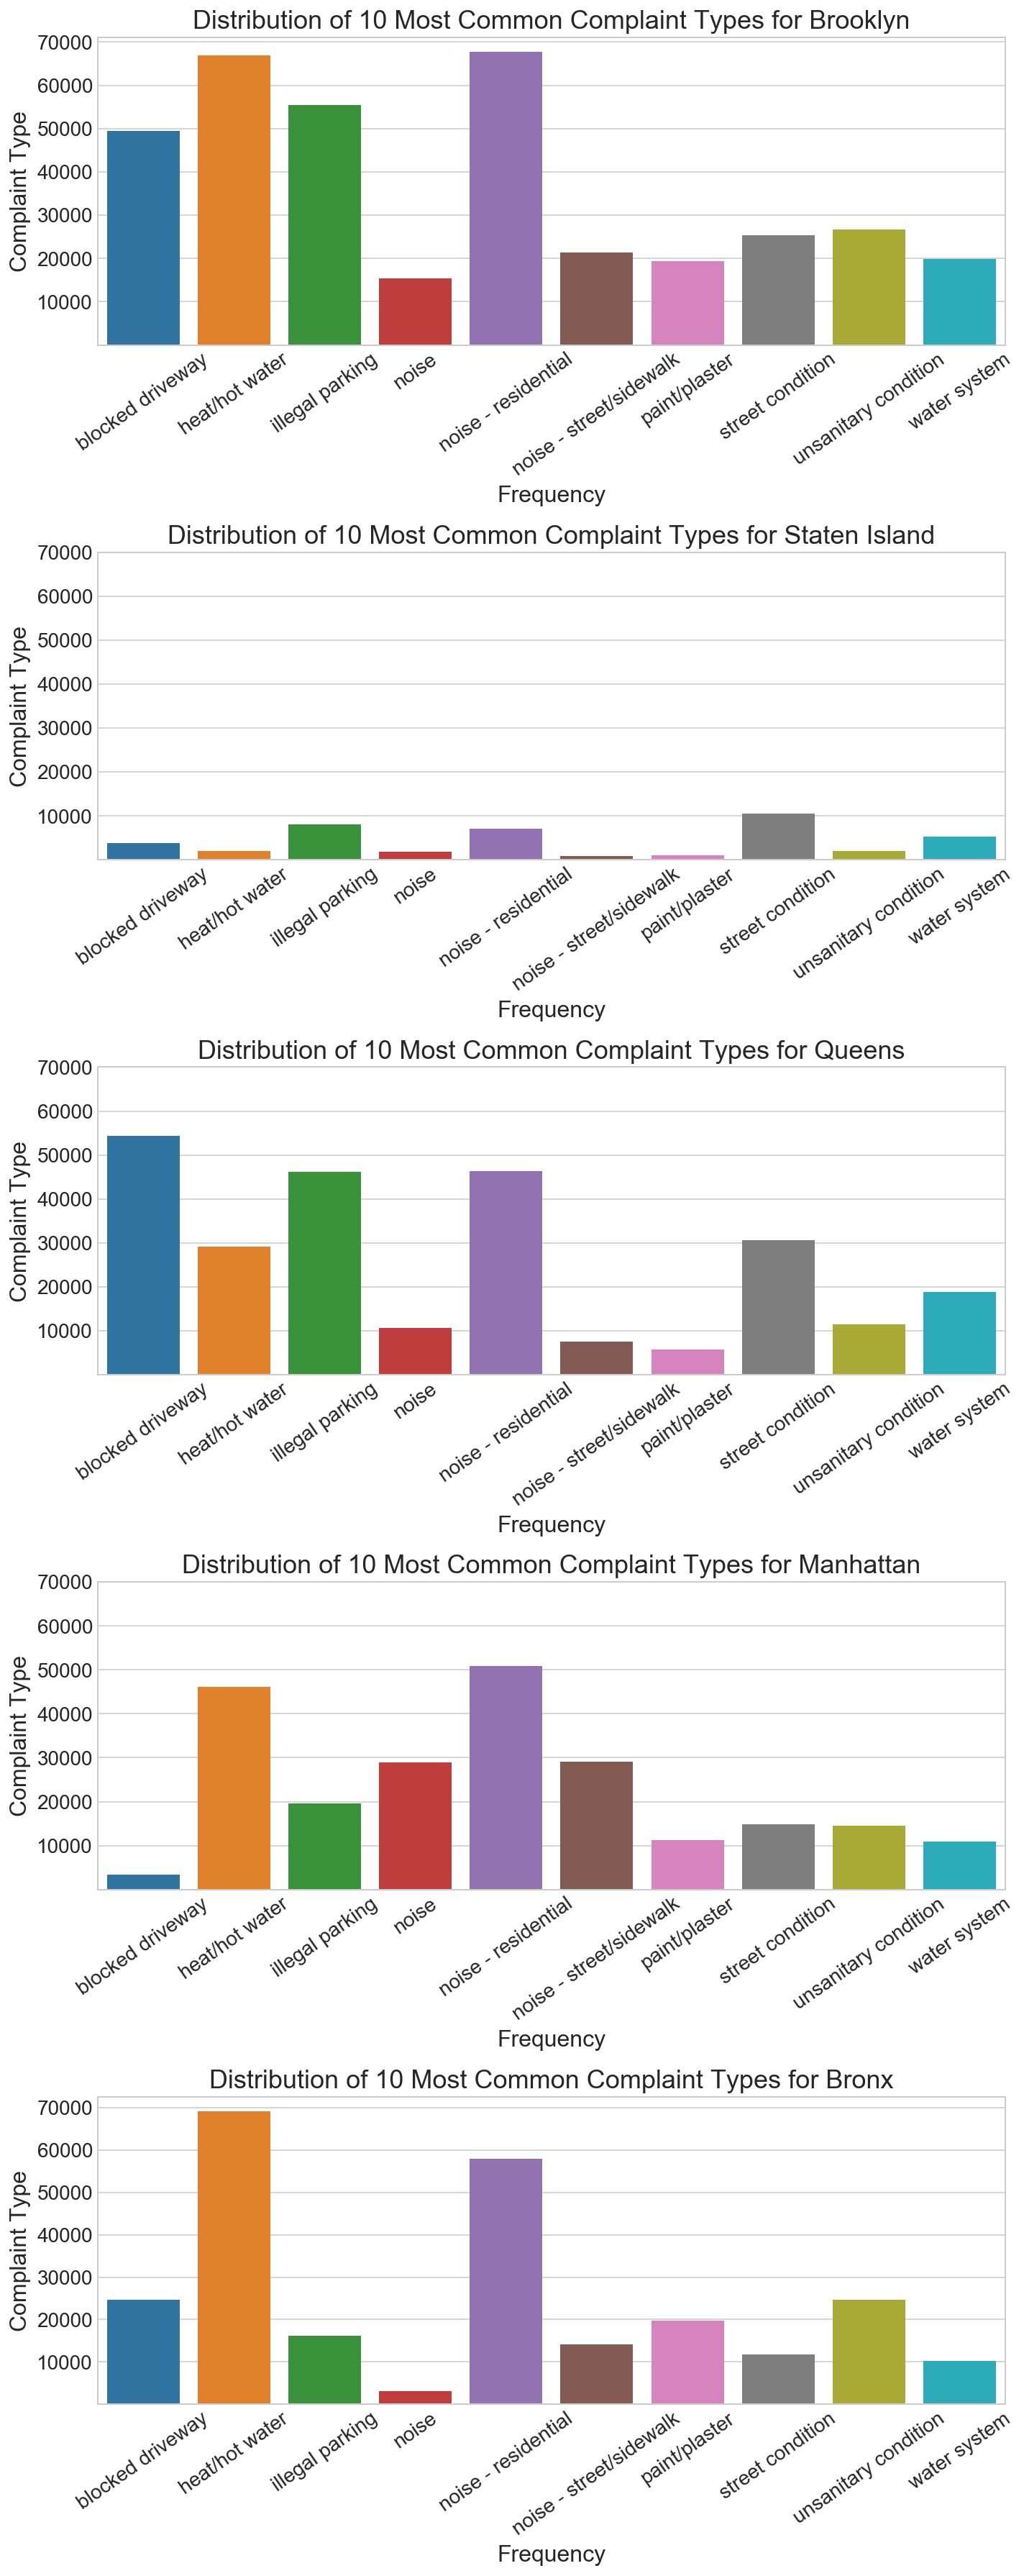

In [26]:
data=df[df['complaint_type'].isin(common_complaints)].sort_values(by='complaint_type')

plt.figure(figsize = (10,25))

for i, borough in enumerate(df['borough'].unique(), start=1):
    plt.subplot(5, 1, i), sns.countplot(x=data[data['borough'] == borough]['complaint_type'])
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Complaint Type', fontsize=16)
    plt.xticks(fontsize=14, rotation=35)
    plt.yticks([10000, 20000, 30000, 40000, 50000, 60000, 70000], fontsize=14)
    plt.title('Distribution of 10 Most Common Complaint Types for ' + str(borough.title()), fontsize=18)
    plt.tight_layout();

# Part 2
---
#### Consider only the 10 most common overall complaint types.  For the 10 most populous zip codes, how many of each of those 10 types were there in 2017?
#### First, identify what the 10 most populous zip codes are. This information, along with the most common incident types, are all that are needed.

In [27]:
zips = df[['zip', 'population']].groupby(['zip', 'population']) \
                                .count() \
                                .sort_values(by='population', ascending=False) \
                                .head(10) \
                                .reset_index()
zips = pd.Series.tolist(zips['zip'])

#### Most of the population is in Brooklyn and Queens.

In [28]:
for zip_code in zips:
    print('{}: {}'.format(zip_code, df[df['zip'] == zip_code]['borough'].unique()[0].title()))

11368: Queens
11226: Brooklyn
11373: Queens
11220: Brooklyn
11385: Queens
10467: Bronx
10025: Manhattan
11208: Brooklyn
11236: Brooklyn
11207: Brooklyn


#### Plotting the data.

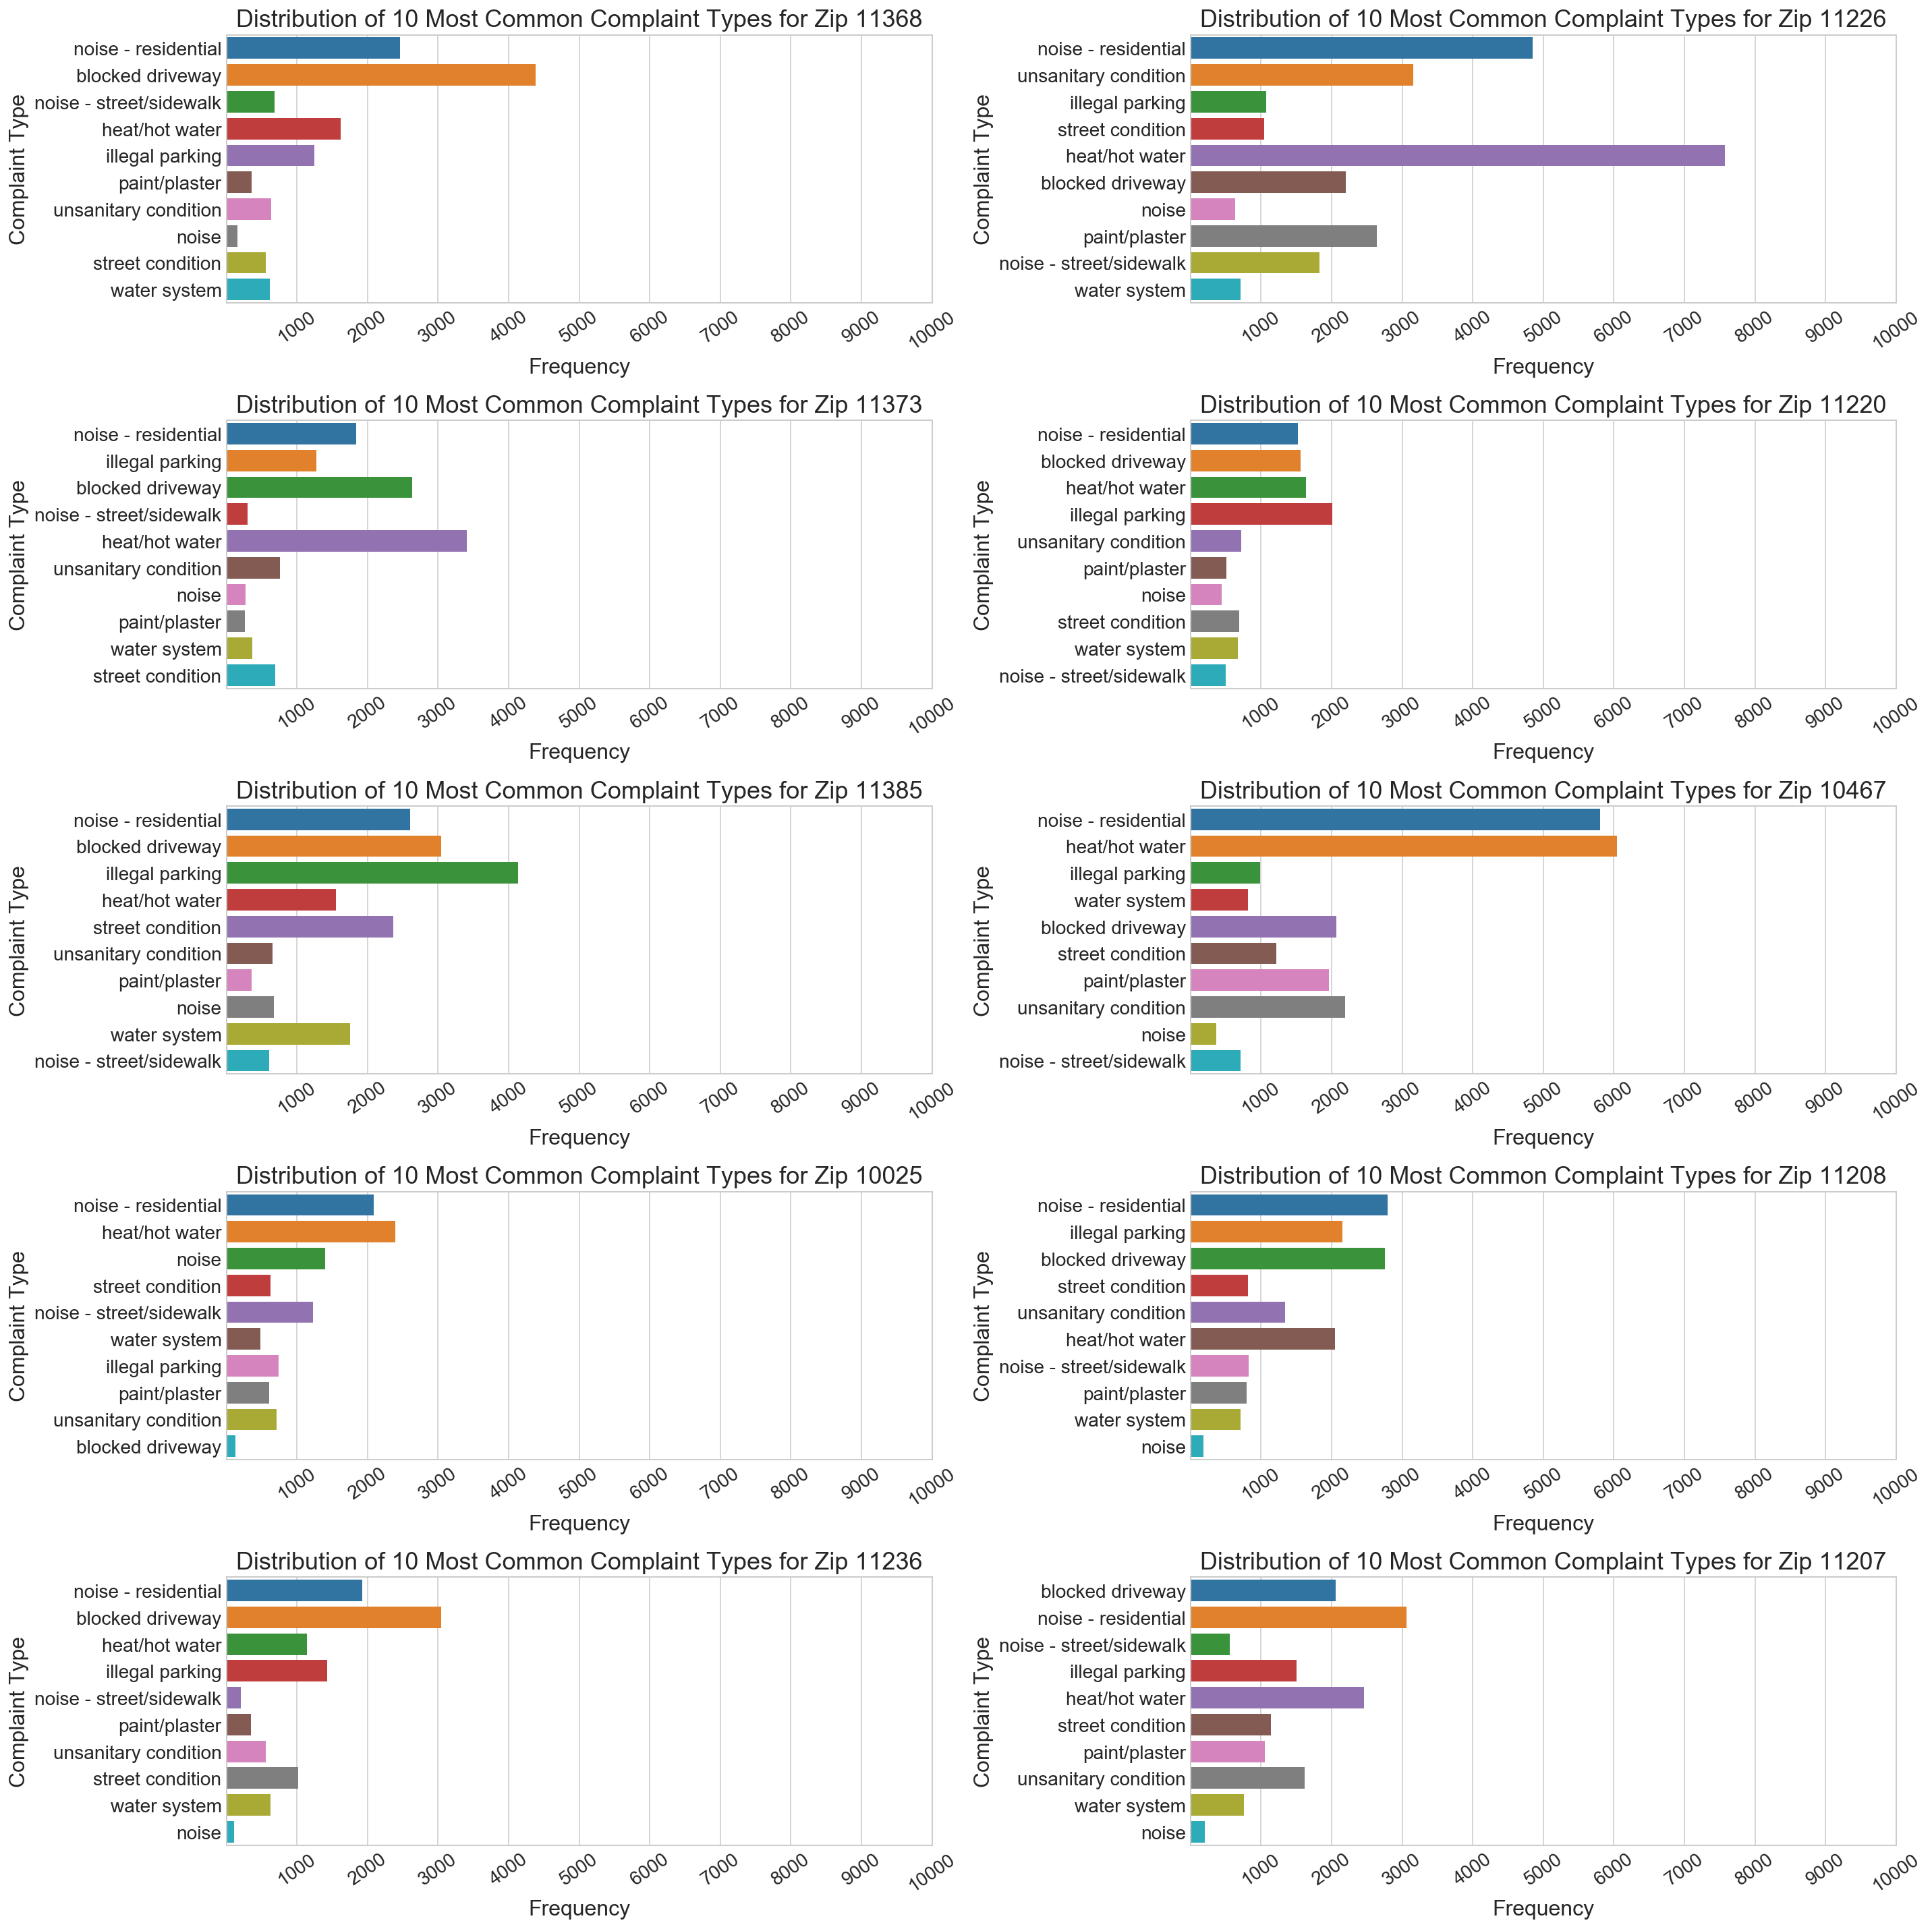

In [29]:
data = df[(df['complaint_type'].isin(common_complaints)) & (df['zip'].isin(zips))]

plt.figure(figsize = (20,20))

for i, zip_code in enumerate(zips, start=1):
    plt.subplot(5, 2, i), sns.countplot(y=data[data['zip'] == zip_code]['complaint_type'])
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Complaint Type', fontsize=16)
    plt.xticks(np.arange(1000, 11000, 1000), fontsize=14, rotation=35)
    plt.yticks(fontsize=14)
    plt.title('Distribution of 10 Most Common Complaint Types for Zip ' + str(zip_code), fontsize=18)
    plt.tight_layout();

# Part 3
---
#### Considering all complaint types. Which boroughs are the biggest "complainers" relative to the size of the population in 2017? Meaning, calculate a complaint-index that adjusts for population of the borough.

#### 48 of the zip codes in the data set do not have an associated population.

In [30]:
zips_without_pop = df[df['population'].isnull()]['zip'].unique()
len(zips_without_pop)

48

#### This accounts to 10,000 lines, so they can be ignored.

In [31]:
df[df['zip'].isin(zips_without_pop)].shape[0]

9824

In [32]:
df = df[df['population'].isnull() == False].copy()

In [33]:
# no unspecified boroughs in this data
df['borough'].unique()

array(['brooklyn', 'staten island', 'queens', 'manhattan', 'bronx'],
      dtype=object)

In [34]:
df = df[['borough', 'zip', 'population', 'complaint_type']]

In [35]:
df.head()

,borough,zip,population,complaint_type
0,brooklyn,11238,49262.0,vacant lot
1,brooklyn,11211,90117.0,vacant lot
2,brooklyn,11211,90117.0,vacant lot
3,staten island,10305,41749.0,vacant lot
4,brooklyn,11208,94469.0,vacant lot


#### Aggregating by complaint type by zip for additional insight and information

In [36]:
df_gby = df.groupby(['zip', 'population', 'complaint_type']).count().reset_index()
df_gby.rename(columns={'borough': 'complaint_count_by_zip'}, inplace=True)

#### Adding borough to back into aggregated dataframe

In [37]:
df_gby['borough'] = 0

brx_zips = df[df['borough'] == 'bronx' ]['zip'].unique()
bk_zips = df[df['borough'] == 'brooklyn' ]['zip'].unique()
mhn_zips = df[df['borough'] == 'manhattan' ]['zip'].unique()
qns_zips = df[df['borough'] == 'queens' ]['zip'].unique()
sil_zips = df[df['borough'] == 'staten island' ]['zip'].unique()

df_gby.loc[df_gby['zip'].isin(brx_zips), 'borough'] = 'bronx'
df_gby.loc[df_gby['zip'].isin(bk_zips), 'borough'] = 'brooklyn'
df_gby.loc[df_gby['zip'].isin(mhn_zips), 'borough'] = 'manhattan'
df_gby.loc[df_gby['zip'].isin(qns_zips), 'borough'] = 'queens'
df_gby.loc[df_gby['zip'].isin(sil_zips), 'borough'] = 'staten island'

df_gby = df_gby[['borough', 'zip', 'population', 'complaint_type', 'complaint_count_by_zip']]

#### Obtaining total population for each borough

In [38]:
total_population_borough =  {}
for borough in df['borough'].unique():
    total_population_borough.update({borough: df[df['borough'] == borough]['population'].unique().sum()})
    print('• {}: {}'.format(borough.title(), str(total_population_borough[borough])))

• Brooklyn: 2504700.0
• Staten Island: 468730.0
• Queens: 2390901.0
• Manhattan: 1595334.0
• Bronx: 1437243.0


In [39]:
df_gby['borough_total_population'] = df_gby['borough'].map(total_population_borough)

In [40]:
df_gby.head()

,borough,zip,population,complaint_type,complaint_count_by_zip,borough_total_population
0,manhattan,10001,21102.0,advocate - other,1,1595334.0
1,manhattan,10001,21102.0,advocate - rpie,1,1595334.0
2,manhattan,10001,21102.0,air quality,59,1595334.0
3,manhattan,10001,21102.0,alzheimer's care,1,1595334.0
4,manhattan,10001,21102.0,animal abuse,33,1595334.0


#### Creating an index that adjusts with population is the product of the two things: 
#### • The proportion of a borough's complaints to total complains.

#### • And, the proportion of a borough's population to total population.

#### The results show that Staten Island is the most likely to complain

In [41]:
complaint_index = {}
total_population = df_gby['borough_total_population'].unique().sum()
for borough in total_population_borough.keys():
    complaint_index.update({borough: (1 - (df_gby[df_gby['borough'] == borough]['complaint_count_by_zip'].sum() / df_gby['complaint_count_by_zip'].sum())) 
                            * (1 - (total_population_borough[borough] / total_population))})
    print('• {}: {}'.format(borough.title(), complaint_index[borough]))
    
df_gby['borough_complaint_index'] = df_gby['borough'].map(complaint_index)

• Brooklyn: 0.4814739729587502
• Staten Island: 0.8933493841659493
• Queens: 0.5401154480338424
• Manhattan: 0.6485567625033779
• Bronx: 0.6729211704255336
